# Gaussian Process Fitting with GausSN

In this notebook, we will take a deep dive into understanding and effectively implimenting kernels and mean functions in Gaussian Process curve fitting. We will be using functions in the GausSN package, written by Erin Hayes with assistance from Dr. Stephen Thorp. 


## Imports
First import the necessary packages.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
jax.config.update('jax_platform_name', 'cpu')

os.chdir('../GausSN')
import gausSN
import kernels
import meanfuncs
os.chdir('../ipynb')

plt.style.use('./stylesheet/GausSN.mplstyle')

## Kernel Functions

Let's start by looking at how a choice of kernel effects how a data set is fit.

The exponential squared kernel takes the form of:

$$
    \large k(x_{i}, x_{j}) = A^{2} e^{\frac{-(x_{i}-x_{j})^{2}}{2\tau^{2}}}
$$

where the scale factor, $A$, and the length scale, $\tau$, are parameters which can be fixed or fitted for when using a GP. Run the below block of code to see how different choices of $A$ and $\tau$ result in different curves when drawing 

/tmp/ipykernel_2597/1894965097.py:5: RuntimeWarning: covariance is not positive-semidefinite.
  y = np.random.multivariate_normal(mean = jnp.zeros(len(x)), cov = cov, size=5)


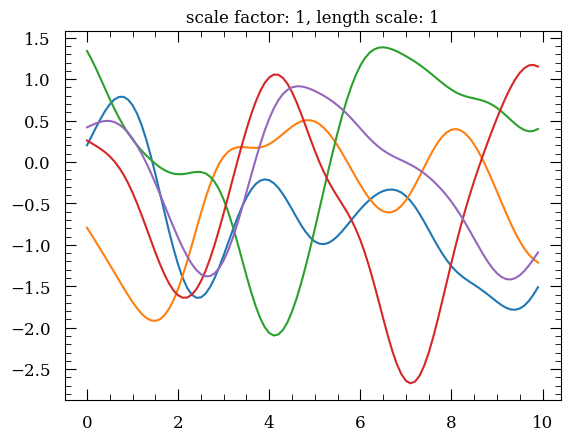

/tmp/ipykernel_2597/1894965097.py:16: RuntimeWarning: covariance is not positive-semidefinite.
  y = np.random.multivariate_normal(mean = jnp.zeros(len(x)), cov = cov, size=5)


<Figure size 640x480 with 0 Axes>

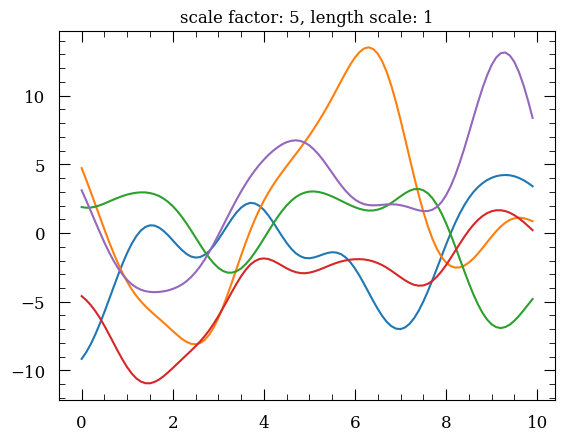

<Figure size 640x480 with 0 Axes>

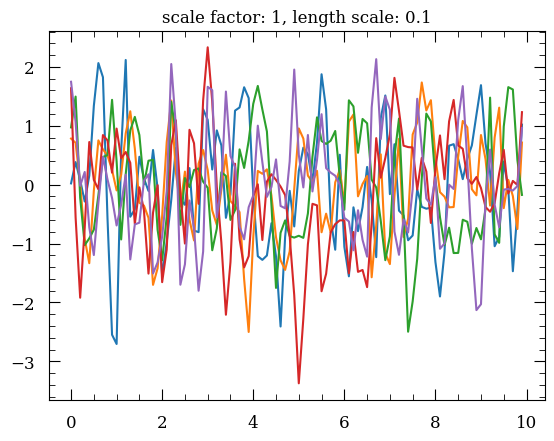

/tmp/ipykernel_2597/1894965097.py:38: RuntimeWarning: covariance is not positive-semidefinite.
  y = np.random.multivariate_normal(mean = jnp.zeros(len(x)), cov = cov, size=5)


<Figure size 640x480 with 0 Axes>

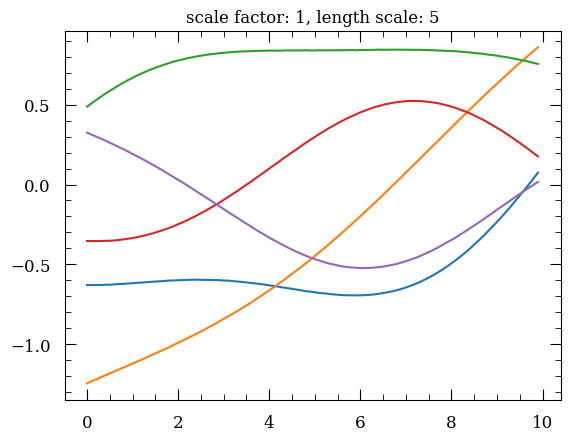

<Figure size 640x480 with 0 Axes>

In [2]:
x = jnp.arange(0, 10, 0.1)
params = [1,1]
kernel = kernels.ExpSquaredKernel(params)
cov = kernel.covariance(x, x)
y = np.random.multivariate_normal(mean = jnp.zeros(len(x)), cov = cov, size=5)
plt.figure()
for i in range(len(y)):
    plt.plot(x, y[i])
plt.title(f'scale factor: {params[0]}, length scale: {params[1]}')
plt.show()
plt.clf()
    
params = [5,1]
kernel = kernels.ExpSquaredKernel(params)
cov = kernel.covariance(x, x)
y = np.random.multivariate_normal(mean = jnp.zeros(len(x)), cov = cov, size=5)
plt.figure()
for i in range(len(y)):
    plt.plot(x, y[i])
plt.title(f'scale factor: {params[0]}, length scale: {params[1]}')
plt.show()
plt.clf()

params = [1,0.1]
kernel = kernels.ExpSquaredKernel(params)
cov = kernel.covariance(x, x)
y = np.random.multivariate_normal(mean = jnp.zeros(len(x)), cov = cov, size=5)
plt.figure()
for i in range(len(y)):
    plt.plot(x, y[i])
plt.title(f'scale factor: {params[0]}, length scale: {params[1]}')
plt.show()
plt.clf()

params = [1,5]
kernel = kernels.ExpSquaredKernel(params)
cov = kernel.covariance(x, x)
y = np.random.multivariate_normal(mean = jnp.zeros(len(x)), cov = cov, size=5)
plt.figure()
for i in range(len(y)):
    plt.plot(x, y[i])
plt.title(f'scale factor: {params[0]}, length scale: {params[1]}')
plt.show()
plt.clf()

We can also see how changing the kernel causes the GP to produce random functions with different properties. We will look at two other kernels besides the exponential squared kernel – specifically the dot product and the Matern $\frac{3}{2}$ kernels.

The dot product kernel is given as:

$$
    \large f(x_{i}, x{j}) = (x_{i} \cdot x_{j})
$$

where $P$ is the power and $\sigma$ is the variance.

The Matern $\frac{3}{2}$ kernel is given by:

$$
    \large f(r^{2}) = (1 + \sqrt{3 r^{2}}) e^{-\sqrt{3 r^{2}}}
$$

where $r$ is the difference between $x_{i}$ and $x_{j}$.

The importance of the kernel in the resulting shape of the fitted curve must be kept in mind when trying to produce the best and most consistent fits possible to the data.

/tmp/ipykernel_2597/4137239952.py:4: RuntimeWarning: covariance is not positive-semidefinite.
  y = np.random.multivariate_normal(mean = np.zeros(len(x)), cov = cov, size=5)


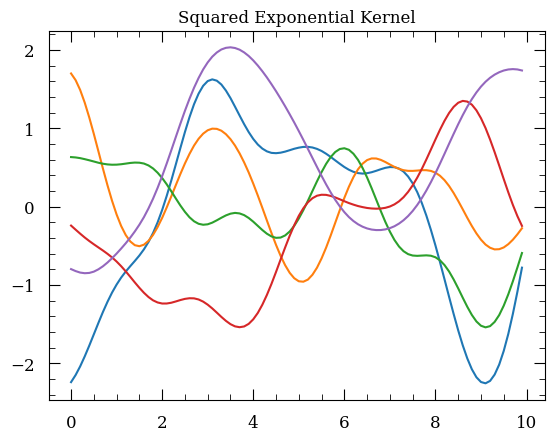

/tmp/ipykernel_2597/4137239952.py:14: RuntimeWarning: covariance is not positive-semidefinite.
  y = np.random.multivariate_normal(mean = np.zeros(len(x)), cov = cov, size=5)


<Figure size 640x480 with 0 Axes>

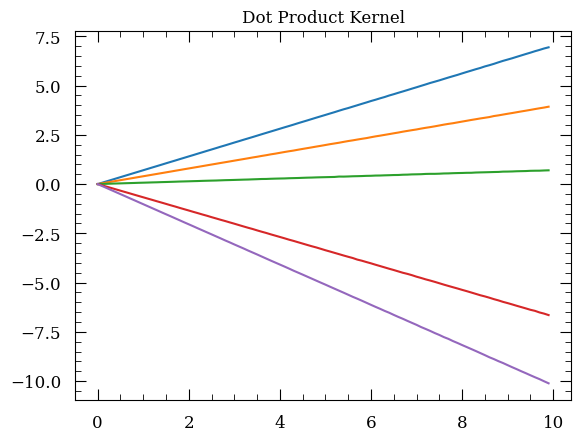

<Figure size 640x480 with 0 Axes>

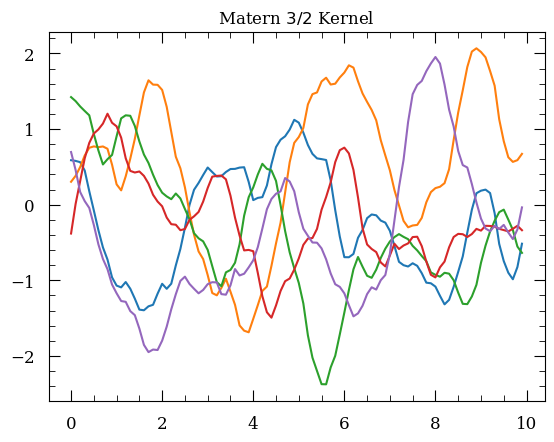

<Figure size 640x480 with 0 Axes>

In [3]:
params = [1, 1]
kernel = kernels.ExpSquaredKernel(params)
cov = kernel.covariance(x, x)
y = np.random.multivariate_normal(mean = np.zeros(len(x)), cov = cov, size=5)
plt.figure()
for i in range(len(y)):
    plt.plot(x, y[i])
plt.title(f'Squared Exponential Kernel')
plt.show()
plt.clf()

kernel = kernels.DotProductKernel()
cov = kernel.covariance(x, x)
y = np.random.multivariate_normal(mean = np.zeros(len(x)), cov = cov, size=5)
plt.figure()
for i in range(len(y)):
    plt.plot(x, y[i])
plt.title(f'Dot Product Kernel')
plt.show()
plt.clf()

kernel = kernels.Matern32Kernel(params)
cov = kernel.covariance(x, x)
y = np.random.multivariate_normal(mean = np.zeros(len(x)), cov = cov, size=5)
plt.figure()
for i in range(len(y)):
    plt.plot(x, y[i])
plt.title(f'Matern $3/2$ Kernel')
plt.show()
plt.clf()

## Mean Functions

The mean function affects the shape of the curve around which the kernel produces deviations to best fit the data. Most of the time, the mean function is set to be a constant, often zero. While the kernel is very powerful and can fit data well without the help of a mean function, if you know something about what your data should look like before fitting, choosing a specific mean function can greatly improve your fits for little extra work on the user's end.

Below, we fix the kernel to be an exponential squared kernel with $A, \tau = 1$ and use different mean functions to illustrate their effect on how data is fit. We show an exponential mean function, a sinusoidal mean function, and a Bazin mean function, as described in Karpenka et al, 2012 as:

$$
    \large f(t) = A [1 + B (t-t_{0})^{2}] \frac{e^{-(t-t_{0})/T_{\textrm{fall}}}}{1 + e^{-(t-t_{0})/T_{\textrm{rise}}}}
$$

where $A$ and $B$ are scaling parameters, $t_{0}$ is the time of the first data point, $T_{\textrm{rise}}$ is the time scale of the rise of the curve, $t_{1}$ is the time of onset of the plateu in the curve, and $T_{\textrm{fall}}$ is the time scale of the fall of the curve. Again, the parameters of the mean function can be fixed or fitted for when fitting the data. This function has been found to be particularly useful for fitting SNIa light curves with GPs, which is why it was included in the GausSN package.

Plotted alongside the GP random draws is the mean function in a thick black line. Note how the functions closely follow the shape of the mean function, with only small deviations caused by the kernel.

/tmp/ipykernel_2597/1653488393.py:4: RuntimeWarning: covariance is not positive-semidefinite.
  y = np.random.multivariate_normal(mean = np.zeros(len(x)), cov = cov, size=5)


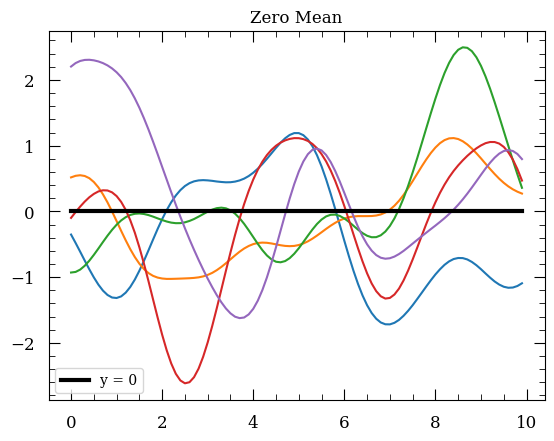

/tmp/ipykernel_2597/1653488393.py:17: RuntimeWarning: covariance is not positive-semidefinite.
  y = np.random.multivariate_normal(mean = mean, cov = cov, size=5)


<Figure size 640x480 with 0 Axes>

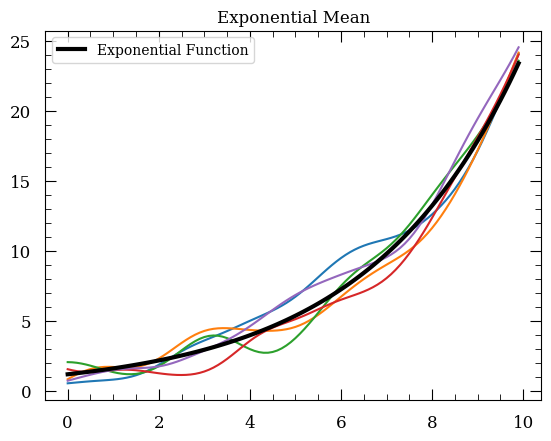

/tmp/ipykernel_2597/1653488393.py:30: RuntimeWarning: covariance is not positive-semidefinite.
  y = np.random.multivariate_normal(mean = mean, cov = cov, size=5)


<Figure size 640x480 with 0 Axes>

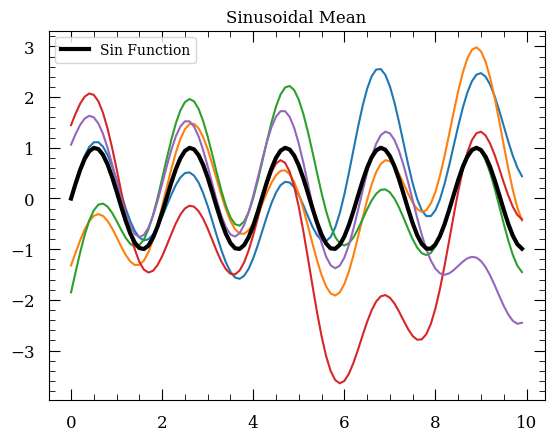

/tmp/ipykernel_2597/1653488393.py:43: RuntimeWarning: covariance is not positive-semidefinite.
  y = np.random.multivariate_normal(mean = mean, cov = cov, size=5)


<Figure size 640x480 with 0 Axes>

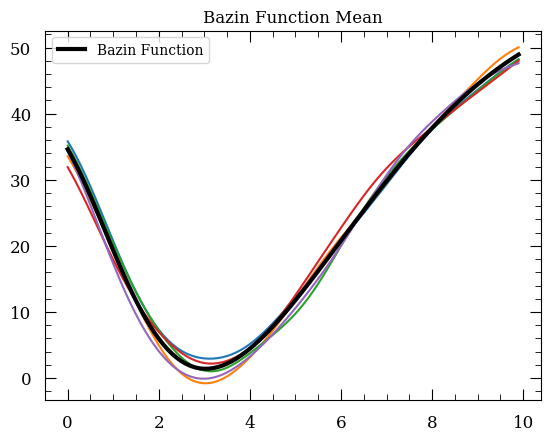

<Figure size 640x480 with 0 Axes>

In [4]:
x = np.arange(0, 10, 0.1)
kernel = kernels.ExpSquaredKernel([1, 1])
cov = kernel.covariance(x, x)
y = np.random.multivariate_normal(mean = np.zeros(len(x)), cov = cov, size=5)
plt.figure()
for i in range(len(y)):
    plt.plot(x, y[i])
plt.plot(x, np.zeros(len(x)), 'k', label='y = 0', lw=3)
plt.title(f'Zero Mean')
plt.legend()
plt.show()
plt.clf()

params = [1.2, 0.3]
meanfunc = meanfuncs.ExpFunction(params)
mean = meanfunc.mean(x)
y = np.random.multivariate_normal(mean = mean, cov = cov, size=5)
plt.figure()
for i in range(len(y)):
    plt.plot(x, y[i])
plt.plot(x, mean, 'k', label='Exponential Function', lw=3)
plt.title(f'Exponential Mean')
plt.legend()
plt.show()
plt.clf()

params = [1, 3, 0]
meanfunc = meanfuncs.Sin(params)
mean = meanfunc.mean(x)
y = np.random.multivariate_normal(mean = mean, cov = cov, size=5)
plt.figure()
for i in range(len(y)):
    plt.plot(x, y[i])
plt.plot(x, mean, 'k', label='Sin Function', lw=3)
plt.title(f'Sinusoidal Mean')
plt.legend()
plt.show()
plt.clf()

params = [1, 1, 3, 0, 5, 1, 0]
meanfunc = meanfuncs.Karpenka2012(params)
mean = meanfunc.mean(x)
y = np.random.multivariate_normal(mean = mean, cov = cov, size=5)
plt.figure()
for i in range(len(y)):
    plt.plot(x, y[i])
plt.plot(x, mean, 'k', label='Bazin Function', lw=3)
plt.title(f'Bazin Function Mean')
plt.legend()
plt.show()
plt.clf()

## Example Curve Fitting

Now we will see an example of how the GP can be used to fit real data. First let's produce some noisy data along the shape of a sinusoidal function.

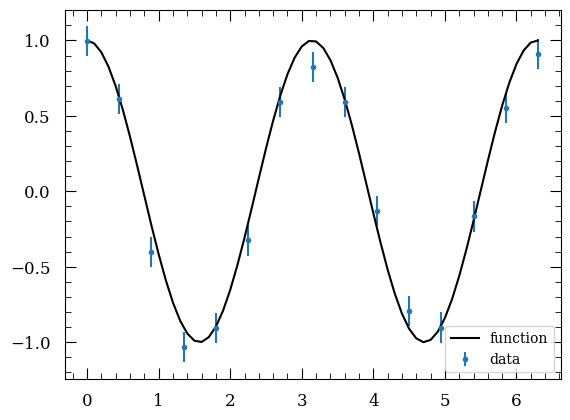

In [5]:
#produce data
x = np.arange(0,2*np.pi+0.45, 0.45)
y = np.cos(2*x)
yerr = np.repeat(0.1, len(x)) #error
y += np.random.normal(0, yerr) #add noise

plt.plot(np.arange(0, 2*np.pi+0.1, 0.1), np.cos(2*np.arange(0, 2*np.pi+0.1, 0.1)), 'k', label='function')
plt.errorbar(x, y, yerr=yerr, label='data', ls='None', marker='.')

plt.legend()

Now, we need to make a choice of kernel and mean function with an arbitrary guess for their parameters. Then, we can run $\texttt{gp.optimize}\_\texttt{parameters(x, y, yerr, bounds)}$ to retrieve the maximum likelihood parameters for the fit. These parameters are fitted for using scipy.optimize.minimize and a multivariate Gaussian log likelihood.

In [6]:
kernel = kernels.ExpSquaredKernel([1, 1])
meanfunc = meanfuncs.UniformMean([0])
gp = gausSN.GP(kernel = kernel, meanfunc = meanfunc)

bounds = [(0.01,5), (0.01,5), (-1,1)]
results = gp.optimize_parameters(x, y, yerr, bounds = bounds)

In [7]:
#see updated kernel and mean func parameters
print(f"A: {gp.kernel.A}\ntau: {gp.kernel.tau}\nc: {gp.meanfunc.c}")

A: 5.0
tau: 1.0
c: 0.99999999


Now we need to create a list of points at which we want to sample the model, x_new, and fit the model at those points given the original data (x, y, yerr).

In [8]:
x_new = np.arange(0,2*np.pi, 0.1) #new points at which to sample the model
expectation, variance = gp.predict(x_new, x, y, yerr)

Using the computed expectation and covariance, we can sample a Multivariate Gaussian to get 10 random fits to the data. Finally, we will plot them alongside the data and the model curve to see how well the GP does!

/tmp/ipykernel_2597/1903080135.py:1: RuntimeWarning: covariance is not positive-semidefinite.
  model = np.random.multivariate_normal(mean=expectation, cov=variance, size=10)


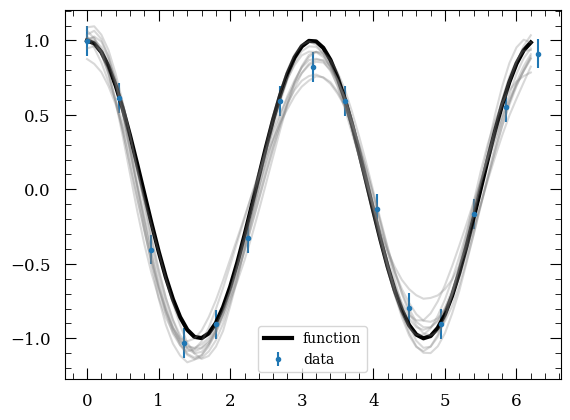

In [9]:
model = np.random.multivariate_normal(mean=expectation, cov=variance, size=10)

plt.plot(x_new, np.cos(2*x_new), 'k', label='function', lw=3)
plt.errorbar(x, y, yerr=yerr, ls='None', marker='.', label='data')

for i in range(len(model)):
    plt.plot(x_new, model[i], color='gray', alpha=0.3)

plt.legend()